In [ ]:
#First trial of ML to find radial velocities. Goal is to use regression to extrapolate the velocities. 

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [3]:
# These are just my choices to make the plots look nice
plt.rcParams.update({'font.family':'cmr10','font.size': 13})
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['axes.labelsize']=15
plt.rcParams['figure.figsize']=(4,4)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [4]:
SimulatedStars = pd.read_csv('rave_tgas_cleaned_data.csv',index_col=None)

In [5]:
SimulatedStars.head()

,Unnamed: 0,ra,dec,b,l,logg,teff,gband,vr,vtheta,...,pmde_err,vU,vV,vW,vU_err,vV_err,vW_err,jband,kband,R_cyl
0,0,160.760542,-13.241389,39.009388,261.198041,4.02,6047.5,11.154045,-22.767779,-8.553811,...,1.109520,2.989305,-26.186428,0.468133,7.397238,2.740294,3.563465,10.313,9.981,8.059333
1,1,160.258125,-13.640972,38.394644,261.014525,1.92,4777.9,10.940921,-90.714933,13.228575,...,1.039390,59.797612,-69.816238,-28.596837,21.613296,8.263897,9.739697,9.513,8.868,8.191753
2,2,159.117958,-13.938889,37.476591,260.143047,3.76,5684.4,9.964015,17.192325,-17.679071,...,0.630677,-32.337603,-30.413529,10.738150,2.762826,0.893481,1.207606,9.107,8.738,8.030682
3,3,159.159667,-13.473472,37.865498,259.816167,3.75,5896.4,9.740564,-19.469996,-8.870117,...,0.576193,4.840963,-15.400051,1.330989,1.266904,0.713310,0.745443,8.843,8.585,8.024455
4,4,160.152417,-11.347833,40.129253,259.072345,2.50,4867.2,10.547413,3.542314,-11.618539,...,0.690997,-31.966993,-30.385995,4.604890,10.842726,1.868670,4.019525,9.129,8.482,8.166834


In [6]:
SimulatedStars.columns

Index(['Unnamed: 0', 'ra', 'dec', 'b', 'l', 'logg', 'teff', 'gband', 'vr',
       'vtheta', 'vphi', 'vr_err', 'vphi_err', 'vtheta_err', 'z', 'z_err',
       'distance', 'distance_err', 'R', 'feH', 'ID', 'hrv', 'hrv_err', 'pmra',
       'pmra_err', 'pmde', 'pmde_err', 'vU', 'vV', 'vW', 'vU_err', 'vV_err',
       'vW_err', 'jband', 'kband', 'R_cyl'],
      dtype='object')

In [7]:
SimulatedStars.shape

(164387, 36)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [9]:
# What columns to use?
use_cols = ['l', 'b','distance','pmra','pmde']
# Make the design matrix
X = SimulatedStars[use_cols].values
Y = (SimulatedStars['vr']).values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size = 0.2,
                                                    random_state=42)

In [11]:
print(X_train.shape)
print(y_train.shape)
print('There are {0} stars in the training set'.format(np.sum(y_train)))
print()
print(X_test.shape)
print(y_test.shape)
print('There are {0} stars in the test set'.format(np.sum(y_test)))

(131509, 5)
(131509,)
There are 40356.09328778812 stars in the training set

(32878, 5)
(32878,)
There are 6386.546530267198 stars in the test set


In [12]:
# Might need to add in a data preprocessing step here 
#Either reweighting the radial velocity or training set features have 0 mean and unit variance

In [13]:
SS = StandardScaler()
X_train = SS.fit_transform(X_train)

In [14]:
# Now scale the test data using the same mean and standard deviation as found with the training data
X_test = SS.transform(X_test)

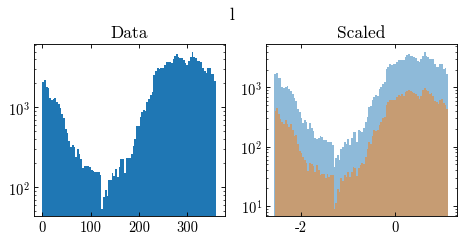

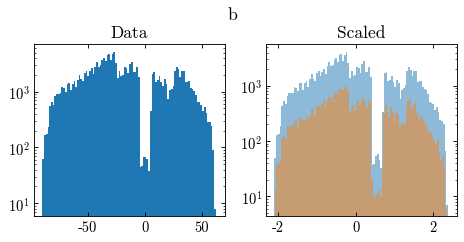

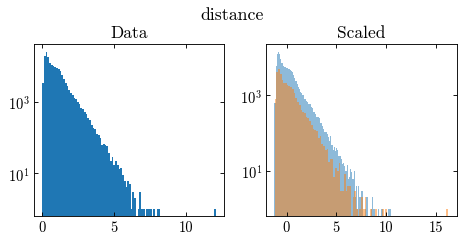

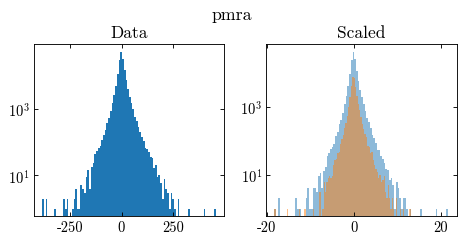

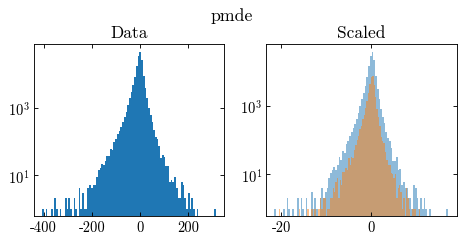

In [15]:
#visualize check data
for i, col in enumerate(use_cols):
    plt.figure(figsize=(6, 3))
    plt.subplot(1,2,1)
    plt.hist(SimulatedStars[col], bins=100)
    plt.yscale('log')
    plt.title('Data')
    
    plt.subplot(1,2,2)
    plt.hist(X_train[:, i], bins=100, alpha=0.5)
    plt.hist(X_test[:, i], bins=100, alpha=0.5)
    plt.yscale('log')
    plt.title('Scaled')
    
    plt.suptitle(col, y=1.01, fontsize=16)
    
    plt.tight_layout()

In [16]:
#Building Classifier 

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


In [18]:
from keras import backend as K

In [19]:
def LikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    SIGMA = K.abs(y_pred[:, 1])
    LOC = y_pred[:, 0]
    X = y_true[:, 0]
    
    ARG = K.square(X - LOC) / (2 * K.square(SIGMA))
    PREFACT = K.log(K.pow(2 * np.pi * K.square(SIGMA), -0.5))
    #you get this from the conditional probability distribution
    return K.mean(ARG - PREFACT)
    #return K.mean(ARG)
#now i'm wondering if somewhere in here I should return SIGMA

In [20]:
MyModel = Sequential()
MyModel.add(Dense(units=100, activation='relu', input_dim=X_train.shape[1]))
MyModel.add(Dense(units=100, activation='relu'))
MyModel.add(Dense(units=100, activation='relu'))
MyModel.add(Dense(units=2))
#using tanh activation function in the last layer
#MyModel.compile(loss='mean_squared_error',
       #         optimizer='adam'
       #       )
MyModel.compile(loss=LikelihoodLossFunction,
                optimizer='adam'
               )

In [21]:
MyModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 21,002
Trainable params: 21,002
Non-trainable params: 0
_________________________________________________________________


In [22]:
#training any checkpoint or early stopping? 
es = EarlyStopping(patience=2, restore_best_weights=True)

In [23]:
print(y_train.shape[0])

131509


In [24]:
history = MyModel.fit(X_train,np.vstack([y_train,
                                  np.ones(y_train.shape[0])
                                  ]).T,
                      validation_split=0.2,
                      epochs=100,
                      batch_size=1000,
                      callbacks = [es]
                     )
#I think in adding the second column to the y_training values that is all 1s can give us an estimate of the error...
#sometimes it trains really well and sometimes not...not sure why it differs so much...maybe it steps in the wrong direction
#intially when optimizing the loss 

Train on 105207 samples, validate on 26302 samples
Epoch 1/100
105207/105207 [==============================] - 1s 6us/step - loss: 241988903.3064 - val_loss: 644.1902
Epoch 2/100
105207/105207 [==============================] - 0s 4us/step - loss: 354.2187 - val_loss: 188.5888
Epoch 3/100
105207/105207 [==============================] - 0s 4us/step - loss: 133.5056 - val_loss: 96.0859
Epoch 4/100
105207/105207 [==============================] - 0s 4us/step - loss: 78.9471 - val_loss: 64.3989
Epoch 5/100
105207/105207 [==============================] - 0s 4us/step - loss: 56.1084 - val_loss: 48.0652
Epoch 6/100
105207/105207 [==============================] - 0s 4us/step - loss: 43.2820 - val_loss: 38.1704
Epoch 7/100
105207/105207 [==============================] - 0s 4us/step - loss: 35.0859 - val_loss: 31.5332
Epoch 8/100
105207/105207 [==============================] - 0s 4us/step - loss: 29.4686 - val_loss: 26.8733
Epoch 9/100
105207/105207 [==============================] - 0s 4u

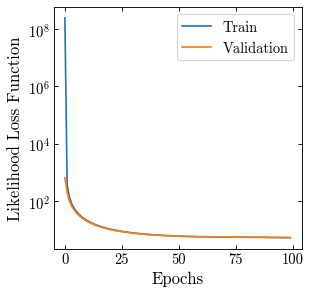

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Likelihood Loss Function')
plt.legend(['Train', 'Validation'])
plt.show()

In [71]:
# predict the scores for the test set, then histogram them based on the real labels
test_preds = MyModel.predict(X_test)
print(test_preds[1:100,1])

[ 73.11663    34.63378    52.743168   44.763092   41.597534   22.449661
  64.48209    90.63253    72.29184    50.07088    78.510895   66.20038
  56.529694   17.082037   96.23159    71.87328    31.508387   77.65035
  30.041891   67.0706     65.5483     19.990765   48.096077   37.81008
  82.04553    34.909054   48.407413   43.498184   84.67639    33.610188
  40.943417   45.085163   65.20912   114.68645    45.012993   62.961006
  16.773111   53.489185   18.842173  124.561104   61.394287   20.712126
  46.601524   27.059465   58.19312    36.945488   28.259907   41.468025
  78.802925   50.195522   76.45894    82.6665     31.494703   89.28551
  31.626205   51.68211    44.577377   10.020179   33.04836    56.463947
  61.659054   92.84995    68.01307    42.88379    42.54746    41.996235
  28.738085   27.689407   14.141478   44.665806   26.818186   57.50461
  86.53401    45.158077   59.528576   24.490913   62.09113    47.673042
  37.879642   19.26224    17.664528   45.28342    33.776836   33.1644

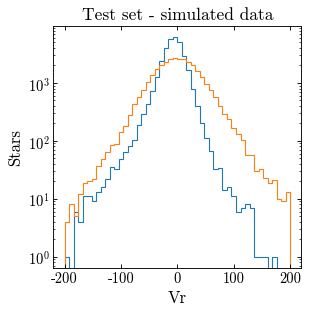

In [72]:
plt.hist(test_preds[:,0], bins=50, range=(-200,200), histtype='step')
plt.hist(y_test, bins=50, range=(-200,200), histtype='step')
plt.xlabel('Vr')
plt.ylabel('Stars')
plt.title('Test set - simulated data')
plt.yscale('log')
plt.show()


Plotting some of the predicted points with confidence as the errorbars 

[0.09218349 0.04093433 0.06505132 0.05442394 0.05020824 0.02470824
 0.08068453 0.11551012 0.09108508 0.06149253 0.09936725 0.08297283
 0.070094   0.01755996 0.12296662 0.09052768 0.03677211 0.09822123
 0.03481912 0.08413175 0.08210444 0.02143363 0.05886261 0.04516433
 0.10407447 0.04130092 0.05927723 0.05273941 0.10757809 0.03957117
 0.04933712 0.05485285 0.08165274 0.1475437  0.05475674 0.07865883
 0.01714855 0.06604483 0.01990401 0.16069417 0.07657237 0.0223943
 0.05687225 0.03084731 0.07230925 0.04401292 0.03244598 0.05003576
 0.09975616]


Text(0, 0.5, 'Error on Vr predicted')

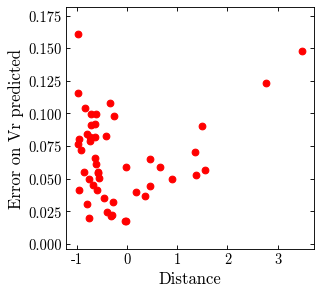

In [73]:
test_preds[:,1] = (test_preds[:,1] - np.min(test_preds[:,1]))/(np.max(test_preds[:,1])- np.min(test_preds[:,1]))
#trying to manually rescale confidence
print(test_preds[1:50,1])
plt.scatter(X_test[1:50,2], test_preds[1:50,1], color = 'red')
#plt.errorbar(X_test[1:50,2], test_preds[1:50,0], yerr = test_preds[1:50,1], color = 'red',ls='none')
plt.xlabel('Distance')
plt.ylabel('Error on Vr predicted')
#maybe good idea to bootstrap bc seems to have differing results for different times that I run it
#ask what is this number??

Text(0, 0.5, 'Vr real')

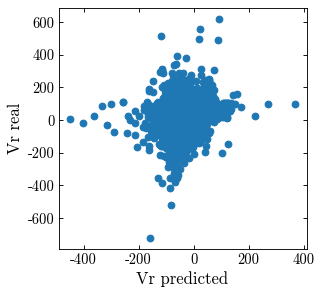

In [48]:
plt.scatter(test_preds[:,0],y_test)
plt.xlabel('Vr predicted')
plt.ylabel('Vr real')

In [49]:
def ConstantLikelihoodFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    LOC = y_pred[:, 0]
    X = y_true[:, 0]
    ARG = -K.square(X - LOC) / (2.0)
    return K.mean(-ARG)

Going to Try Calculating the Mean and Error from two different networks...although I'm not sure how this will give us the error on the network that calculates the mean...unless we can somehow transfer over the information from the weights

In [50]:
from keras.layers import Input, Dense, Lambda, Concatenate
from keras.models import Model
from keras.utils import plot_model

In [51]:
# del(inputs, MeanEst, MeanModel, ConfEst, ConfModel)
inputs = Input(shape=(5,))
MeanEst = (Dense(100, activation='relu'))(inputs)
MeanEst = (Dense(100, activation='relu'))(MeanEst)
MeanEst = (Dense(100, activation='relu'))(MeanEst)
MeanEst = (Dense(1, activation='linear'))(MeanEst)
MeanModel = Model(inputs, MeanEst)

ConfEst= (Dense(100, activation='tanh'))(inputs)
ConfEst= (Dense(100, activation='tanh'))(ConfEst)
ConfEst= (Dense(100, activation='tanh'))(ConfEst)
ConfEst= (Dense(1, activation='relu'))(ConfEst)
ConfModel = Model(inputs, ConfEst)
#this can't possibly give me a confidence output? the only thing that appears to define a confidence is the relu
#on the last layer 
#CombinedSub = Concatenate(axis=-1)([MeanEst, ConfEst])
CombinedSub = Concatenate(axis=-1)([MeanModel(inputs), ConfModel(inputs)])

CombinedModel = Model(inputs, CombinedSub)
#plot_model(CombinedModel,to_file='demo.png',show_shapes=True)

In [52]:
CombinedModel.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            20901       input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            20901       input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2)            0           model_1[1][0]                    
                                                                 model_2[1][0]              

In [ ]:
ConfModel.trainable = False
MeanModel.trainable = True
CombinedModel.compile(loss=ConstantLikelihoodFunction,
                      optimizer='adam'
                     )
#why does the loss only return not nan when I use this ...I'm guessing it has to do with the log...
CombinedModel.fit(X_train,y_train,
                  epochs=100,
                  batch_size=1000,
                  validation_split=0.2
                 )

In [ ]:
ConfModel.trainable = True
MeanModel.trainable = False
CombinedModel.compile(loss=ConstantLikelihoodFunction,
                      optimizer='adam'
                     )

CombinedModel.fit(X_train,y_train,
                  epochs=100,
                  batch_size=1000,
                  validation_split=0.1
                 )

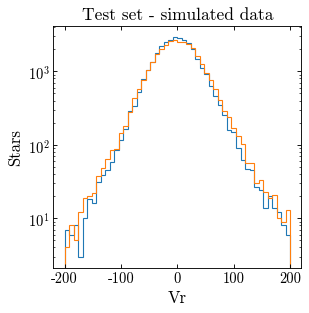

In [57]:
test_preds_2 = CombinedModel.predict(X_test)
plt.figure()
plt.hist(test_preds_2[:,0], bins=50, range=(-200,200), histtype='step')
plt.hist(y_test, bins=50, range=(-200,200), histtype='step')
plt.xlabel('Vr')
plt.ylabel('Stars')
plt.title('Test set - simulated data')
plt.yscale('log')
plt.show()

[0.33220997 0.1404052  0.0650609  0.21515281 0.17435847 0.06300502
 0.27721444 0.25311586 0.3057027  0.19588776 0.35261238 0.
 0.         0.00491727 0.         0.         0.01598033 0.16228598
 0.         0.23719586 0.33013657 0.03691034 0.         0.
 0.2934952  0.12545295 0.17195697 0.         0.1477449  0.
 0.25890273 0.2612983  0.30319786 0.         0.0395855  0.35436657
 0.03385221 0.15831415 0.09066331 0.27347696 0.13838378 0.08409004
 0.         0.         0.29760873 0.         0.         0.
 0.327172  ]


Text(0, 0.5, 'Error on Vr predicted')

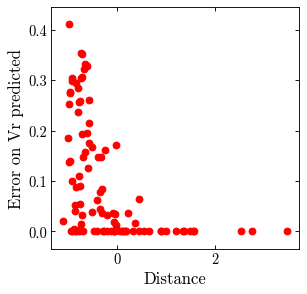

In [74]:
print(test_preds_2[1:50,1])
plt.scatter(X_test[1:100,2], test_preds_2[1:100,1], color = 'red')
#plt.errorbar(X_test[1:50,2], test_preds_2[1:50,0], yerr = test_preds_2[1:50,1], color = 'red',ls='none')
plt.xlabel('Distance')
plt.ylabel('Error on Vr predicted')
#does give a relu output...but I'm still not sure if this is exactly showing the error
